In [1]:
from pathlib import Path
import json
from tqdm import tqdm
import subprocess
import sys
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst, equilibrate_graphene

In [3]:
# Read setting file
ROOT_DIR = WORK_DIR.parent
with open(ROOT_DIR / "settings.json", "r") as f:
    settings = json.load(f)
partition = settings["partition"]
PART_DIR = ROOT_DIR / "data" / f"{partition}_partition_data"
FP_DIR = PART_DIR / "fingerprints"
RES_DIR = WORK_DIR / "results" / f"{partition}_partition"
if not RES_DIR.exists():
    RES_DIR.mkdir(parents=True)

In [4]:
# DFT data
dft_data = np.loadtxt("../energyvslatconst/dft_data.txt", delimiter=",")

In [5]:
##########################################################################################
# Dropout
# -------

dropout_data = np.load(
    ROOT_DIR
    / "training_dropout"
    / "results"
    / "dropout"
    / f"{partition}_partition"
    / "uncertainty_energy_vs_latconst_graphene.npz"
)
alist = dropout_data["alist"]
energy_ensembles_do = dropout_data["energy_ensembles"]
energy_mean_do = np.mean(energy_ensembles_do, axis=0)
energy_error_do = np.std(energy_ensembles_do, axis=0)

In [6]:
##########################################################################################
# FIM
# ---
preds_samples_file = RES_DIR / "uncertainty_energy_vs_latconst_graphene.npz"
if preds_samples_file.exists():
    preds_data = np.load(preds_samples_file)
    preds_samples = preds_data["energy_ensembles"]
else:
    preds_samples = np.empty((0, len(alist)))
    for ii in tqdm(range(100)):
        # Predictions
        modelname = f"DUNN_C_fimbayes_{ii:03d}"
        _, eng, _ = energyvslatconst(modelname, alist, "graphene", 0)
        preds_samples = np.row_stack((preds_samples, eng))
    preds_samples = preds_samples.astype(float)
    np.savez(preds_samples_file, alist=alist, energy_ensembles=preds_samples)

In [7]:
mean_samples_target = np.mean(preds_samples, axis=0)
err_samples_target = np.std(preds_samples, axis=0)

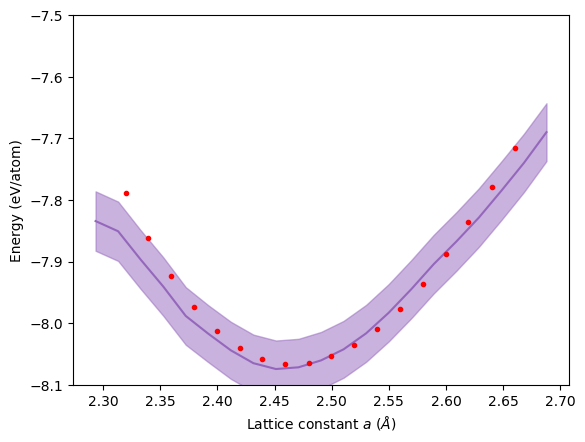

In [8]:
# Plot
plt.figure()
plt.plot(*(dft_data.T), "r.", zorder=10, label="DFT")
# FIM
plt.fill_between(
    alist,
    mean_samples_target + err_samples_target,
    mean_samples_target - err_samples_target,
    alpha=0.5,
    color="tab:purple",
)
plt.plot(alist, mean_samples_target, color="tab:purple", label="DUNN FIM")

# # Dropout
# plt.fill_between(
#     alist,
#     energy_mean_do + energy_error_do,
#     energy_mean_do - energy_error_do,
#     alpha=0.5,
#     color="tab:orange",
# )
# plt.plot(alist, energy_mean_do, color="tab:orange", label="DUNN dropout")

plt.ylim(-8.1, -7.5)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")
# plt.legend()

plt.show()